In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import arrow
import pytz
from tzlocal import get_localzone
import PIconnect as PI
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Pré-Processamento 

In [2]:
#substituir bad data por NaN
def fix_bad_data(df, bad_data=["Bad Data","No Data","Bad","I/O Timeout","Calc Failed",
                               "Arc Off-line","Comm Fail","Configure","Intf Shut"]):
    df = df.apply(lambda x: x.replace(bad_data, np.nan), axis=0)
    return df

In [3]:
#coluna "dummies" numéricas para as famílias de papel que são string
def dummies_LINHA(df):
    
    list_fam = df['LINHA'].unique()
    list_dum = [(i+1) for i in list(range(len(df['LINHA'].unique())))]
    
    replace_values = dict(zip(list_fam,list_dum))
        
    df['LINHA'] = df['LINHA'].replace(replace_values)
    
    return df

In [4]:
#preparar dados do csv de treinamento
def prepare_df(dataframe):
    
    features = dataframe #dataframe fornecido
    
    #familia do cartão
    if 'LINHA' in list(features.columns.values):
        pass
    else:
        features["LINHA"] = features["B6FPGRADE"].str[0:3]
    
    #substituir os valores Bad Data por NaN
    features = fix_bad_data(features)
    
    features = dummies_LINHA(features)

    #converter colunas (menos TIMESTAMP, LINHA e PROD) para valor numérico
    for i in list(features.columns.values):
        if i in ["TIMESTAMP","LINHA","B6FPGRADE","B6OPT_ROLO"]:
            pass
        else:
            if features[i].dtype == 'O':
                features[i] = features[i].astype('float64')
    
    #adicionar tags - CALCULAR FLUXO DE CELULOSE COM TAGS DISPONÍVEIS
    features["GSL1"] = (features["B6MFVAT01WFPV"]*features["B6AI0405PV"])/features["B6P1XDHDRESPDAPV"]
    features["GSL4"] = (features["B6MFVAT04WFPV"]*features["B6AI0480PV"])/features["B6P1XDHDRESPDAPV"]
    features["GSL2"] = (features["B6MFVAT02WFPV"]*features["B6AI0430PV"])/features["B6P1XDHDRESPDAPV"]
    
    features = features.drop(columns = ["B6MFVAT01WFPV","B6MFVAT04WFPV","B6MFVAT02WFPV","B6AI0405PV",
                                        "B6AI0480PV","B6AI0430PV"])
    
    #filtro de quebras
    tags_quebras = ['QUEBRAS_MB6_HST','B6P1XDHD.BRKAC']
    for i in tags_quebras:
        if i in list(features.columns.values):
            features = features[features[i] == 0]
            features = features.drop(columns = [i])
            
    #excluir linha que contém valores nulos
    features = features.dropna(axis=0)

    #excluir possiveis linhas duplicadas
    features = features.drop_duplicates()
                
    return features

### Modelo de Predição

In [5]:
#csv para treinamento
train_df = pd.read_excel('train_novo.xlsx',sep = ';',decimal = ',',encoding = 'UTF-8')

In [6]:
df = prepare_df(train_df)

In [7]:
#retornar as familias que estão no treinamento do modelo - não predizer familias desconhecidas
def fam_pred(df):
    
    dict_fam = {'Fam_rigidez': list(df['LINHA'].unique())}
    return dict_fam

In [8]:
#tratar o dataframe pré-predição

def final_prep(df):

    #tratar dados do tipo NaN e Infinitos
    df[df==np.inf]=np.nan
    df = df.dropna(axis=0)

    #eliminar outliers
    df = df[df['B6OPT_119_AVG']<= 600] #maior LimSup de rigidez L
    df = df[df['B6OPT_120_AVG']<= 300] #maior LimSup de rigidez T
    
    return df

In [9]:
df = final_prep(df)

In [10]:
#tags de rigidez do laboratório
target = df[['B6OPT_119_AVG','B6OPT_120_AVG']]

#tirar targets + timestamp e numero do rolo
features = df.drop(columns = ['TIMESTAMP','B6OPT_ROLO','B6OPT_119_AVG','B6OPT_120_AVG','B6FPGRADE']) 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size = 0.3, random_state = 5)

In [12]:
model = RandomForestRegressor()

In [13]:
model.fit(x_train,y_train)

c:\users\jtsantos\my-venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
predict_rigidez = model.predict(x_test)

In [15]:
pred = pd.DataFrame(data = model.predict(x_test),columns = ['B6OPT_119_AVG_pred','B6OPT_120_AVG_pred'])

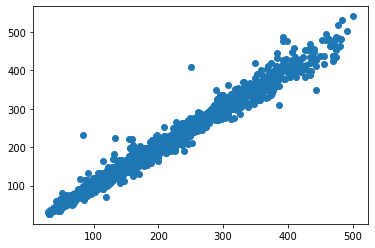

In [16]:
plt.scatter(pred,y_test)

### Avaliação

In [17]:
#RMSE DAS PREDIÇÕES
#PI Notification quando o erro estiver muito alto?

In [18]:
def score_RMSE (pred,y_test):
    
    RMSE_L = np.sqrt(mean_squared_error( y_test['B6OPT_119_AVG'],pred['B6OPT_119_AVG_pred'])) #LONGITUDINAL
    RMSE_T = np.sqrt(mean_squared_error(y_test['B6OPT_120_AVG'],pred['B6OPT_120_AVG_pred'])) #TRANSVERSAL
        
    return RMSE_L, RMSE_T

In [19]:
#REGRESSÃO LINEAR DOS DADOS
#PI Notification quando o erro estiver baixo?

In [20]:
def score_r2(pred,y_test):
    
    df_L = pd.DataFrame(data = {'L_true': list(y_test['B6OPT_119_AVG'].values),
                                'L_pred': list(pred['B6OPT_119_AVG_pred'].values)})
    df_T = pd.DataFrame(data = {'T_true': list(y_test['B6OPT_120_AVG'].values),
                                'T_pred': list(pred['B6OPT_120_AVG_pred'].values)})
    
    r2_L = r2_score(df_L[['L_true']],df_L[['L_pred']])
    r2_T = r2_score(df_T[['T_true']],df_T[['T_pred']])
    
    return r2_L, r2_T

In [21]:
RMSE_L, RMSE_T = score_RMSE (pred,y_test)
r2_L, r2_T = score_r2(pred,y_test)

l_total = [round(RMSE_L,4), round(RMSE_T,4),round(r2_L,4), round(r2_T,4)]
l_total

[11.7985, 7.5255, 0.9841, 0.969]

In [22]:
linha = x_test['LINHA'].to_list()

l1 = pred['B6OPT_119_AVG_pred'].to_list()
l2 = pred['B6OPT_120_AVG_pred'].to_list()

l3 = y_test['B6OPT_119_AVG'].to_list()
l4 = y_test['B6OPT_120_AVG'].to_list()

In [23]:
df_pred = pd.DataFrame(data = {'LINHA': linha, 'B6OPT_119_AVG': l3, 'B6OPT_119_AVG_pred': l1, 
                               'B6OPT_120_AVG': l4, 'B6OPT_120_AVG_pred': l2})

In [24]:
list_fam = ['SBA', 'DUO', 'BCO', 'TWP', 'TFP', 'S6N', 'TPR', 'CBO', 'TPW','BCC']
list_dum = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_pred['LINHA'] = df_pred['LINHA'].replace(dict(zip(list_dum,list_fam)))

In [25]:
list_df = []
for i in list_fam:
    df_aux = df_pred[df_pred['LINHA']==i]
    list_df.append(df_aux)

In [26]:
list_scr = []

for i in list_df:
    
    pred = i.drop(columns = ['LINHA', 'B6OPT_119_AVG', 'B6OPT_120_AVG'])
    y_test = i.drop(columns = ['LINHA', 'B6OPT_119_AVG_pred', 'B6OPT_120_AVG_pred'])
    RMSE_L, RMSE_T = score_RMSE(pred,y_test)
    r2_L, r2_T = score_r2(pred,y_test)
    list_scr.append([round(RMSE_L,4), round(RMSE_T,4),round(r2_L,4), round(r2_T,4)])    

c:\users\jtsantos\my-venv\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\jtsantos\my-venv\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [27]:
print('RMSE_L, RMSE_T, r2_L, r2_T')

for i in range(len(list_df)):
    print(i, list_fam[i],len(list_df[i]), list_scr[i])

RMSE_L, RMSE_T, r2_L, r2_T
0 SBA 386 [11.5097, 8.1561, 0.9699, 0.9349]
1 DUO 74 [8.0505, 5.5276, 0.9709, 0.942]
2 BCO 44 [7.2857, 23.3631, 0.9468, 0.4613]
3 TWP 1031 [10.5738, 5.876, 0.9884, 0.9831]
4 TFP 97 [17.8494, 10.5141, 0.9739, 0.9509]
5 S6N 846 [12.9335, 7.0811, 0.974, 0.9591]
6 TPR 3 [12.0716, 8.9016, -0.0896, -1.8925]
7 CBO 1 [3.273, 0.145, nan, nan]
8 TPW 6 [5.7289, 2.3952, 0.5131, -3.3216]
9 BCC 2 [2.9795, 4.8803, -0.1782, -5.7387]


In [28]:
#TPR e TPW em um df só
df_tp = list_df[6].append(list_df[8])

pred = df_tp.drop(columns = ['LINHA', 'B6OPT_119_AVG', 'B6OPT_120_AVG'])
y_test = df_tp.drop(columns = ['LINHA', 'B6OPT_119_AVG_pred', 'B6OPT_120_AVG_pred'])
RMSE_L, RMSE_T = score_RMSE(pred,y_test)
r2_L, r2_T = score_r2(pred,y_test)

l_tp = [round(RMSE_L,4), round(RMSE_T,4),round(r2_L,4), round(r2_T,4)]
l_tp

[8.3937, 5.4989, 0.9752, 0.8791]

In [29]:
#BCO, CBO e BCC em um df só
df_copo = list_df[2].append(list_df[7])
df_copo = df_copo.append(list_df[9])

pred = df_copo.drop(columns = ['LINHA', 'B6OPT_119_AVG', 'B6OPT_120_AVG'])
y_test = df_copo.drop(columns = ['LINHA', 'B6OPT_119_AVG_pred', 'B6OPT_120_AVG_pred'])
RMSE_L, RMSE_T = score_RMSE(pred,y_test)
r2_L, r2_T = score_r2(pred,y_test)

l_copo = [round(RMSE_L,4), round(RMSE_T,4),round(r2_L,4), round(r2_T,4)]
l_copo

[7.0922, 22.6276, 0.9494, 0.4712]

### Salvar o modelo 

In [30]:
def save_model(modelo, fname):
    """
    Pickles model under "self.reg".
    :param fname: path/to/file where to save model
    """
    with open(fname, 'wb') as ofile:
        pickle.dump(modelo, ofile, pickle.HIGHEST_PROTOCOL)

def load_model(modelo, fname):
    """
    Loads model under "self.reg".
    :param fname: path/to/file where model is pickled.
    """
    with open(fname, 'rb') as ifile:
        reg = pickle.load(ifile)
        
    return reg

In [31]:
save_model(model,'predict_rigidez')

### Predição online

In [32]:
#trocar valores das tags de gramatura, espessura e umidade do lab. utilizados no modelo para TAGS DO SCANNER

### Snapshot: quebra e familia

In [33]:
#snapshot_quebras
#se estiver em quebra, não realiza predição! se quebras_ultimo_valor != 0 
#atribuir ultimo valor calculado à tag - CONGELAMENTO - valor da tag em PIWebAPI

In [34]:
#snapshot_familia
#se estiver fabricando uma familia desconhecida, não realiza predição! se LINHA not in familias_do_dicionario
#atribuir ultimo valor calculado à tag - CONGELAMENTO - valor da tag em PIWebAPI

### Bias de correção

In [35]:
#bias - regressao linear do valor_real_rigidez x predicao
#A REGRESSÃO LINEAR CONSEGUE AMENIZAR OUTLIERS DA PREDIÇÃO

In [36]:
def bias_reglin_L(pred,y_test):

    df_L = pd.DataFrame(data = {'L_true': list(y_test['B6OPT_119_AVG'].values),
                                'L_pred': list(pred['B6OPT_119_AVG_pred'].values)})
    
    model_L = LinearRegression().fit(df_L[['L_true']], df_L[['L_pred']])
    
    L_reglin = model_L.coef_[0][0]*df_L[['L_true']] + model_L.intercept_[0]
    
    r2_L = r2_score(df_L[['L_true']],L_reglin)

    return r2_L, L_reglin

In [37]:
r2_L,L_reglin = bias_reglin_L(pred,y_test)
r2_L

0.9949225734687214

In [38]:
def bias_reglin_T(pred,y_test):

    df_T = pd.DataFrame(data = {'T_true': list(y_test['B6OPT_120_AVG'].values),
                                'T_pred': list(pred['B6OPT_120_AVG_pred'].values)})
    
    model_T = LinearRegression().fit(df_T[['T_true']], df_T[['T_pred']])
    
    T_reglin = model_T.coef_[0][0]*df_T[['T_true']] + model_T.intercept_[0]
    
    r2_T = r2_score(df_T[['T_true']],T_reglin)

    return r2_T, T_reglin

In [39]:
r2_T, T_reglin = bias_reglin_T(pred,y_test)
r2_T

0.5948644480771214